In [110]:
import pandas as pd
import re
# all sentences
# df = pd.read_csv("all_sents_aug.csv").dropna().reset_index()

# only canonical sentences in eng
df = pd.read_csv("canonical_sents_aug.csv").dropna().reset_index()

In [111]:
sentences = df["preprocessed_text"]
sentences = [re.sub(r'\s([?.!"](?:\s|$))', r'\1', x).strip() for x in sentences]
labels = [1] * len(sentences) # synthetic broca data

In [112]:
len(sentences)

22193

In [113]:
sentences

['So i have two children.',
 'One of my children is adopt.',
 'So i tell story my son being bear.',
 'So i guess we talk my daughter and adoption.',
 'We try have children many years and not get.',
 'But i was bind and determine be mom.',
 'Then we start pursue adoption route.',
 'So you know we say we just wait her.',
 'Also i adopt child.',
 'But you know lot people say.',
 'It not feel my child.',
 'That she like adopt child foster system.',
 'Boy play soccer his yard.',
 'One time he kick it bit too.',
 'He kick it his front window.',
 'His dad sit living room.',
 'Ball come window and knock lamp.',
 'So boy get go school.',
 'His mother say.',
 'Johnny you need take umbrella.',
 'It go rain today.',
 'He say.',
 'I not need umbrella.',
 'He leave.',
 'As he get school it start rain.',
 'Then it start rain.',
 'He turn around.',
 'He go back home and tell his mom.',
 'It start rain.',
 'He end up take umbrella and walk back to school.',
 'Girl ride along her tricycle her yard.',
 '

# BERT

In [1]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import torch     
import pandas as pd
import evaluate
metric = evaluate.load("accuracy")

In [2]:
tokenizer = AutoTokenizer.from_pretrained("C:/Users/imruh/Documents/Uni/Master thesis/classifiers/models/bert_finetuned", return_tensor="pt")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = AutoModelForSequenceClassification.from_pretrained("C:/Users/imruh/Documents/Uni/Master thesis/classifiers/models/bert_finetuned")
model = model.to(device)

In [3]:
df = pd.read_csv("../linguistic_model/data/synthetic_clan.csv")
# df = pd.read_csv("../linguistic_model/data/synthetic_misra.csv")
# df = pd.read_csv("../linguistic_model/data/synthetic_salis.csv")

In [4]:
df

,modified,label
0,"thus 3, and 2 an movie.",1
1,it could be fun with the cool looking aliens a...,0
2,there are much better kay francis vehicles out...,0
3,seeing her in a bra and panty and later in a b...,0
4,but the voiceartists cannot be blamed for the ...,0
...,...,...
903,nobody should that.,1
904,0 10,1
905,"there are bad movies, terrible movies even bor...",0
906,s problem one.,1


In [5]:
sentences = df['modified']
labels = df["label"]

In [6]:
device

'cuda:0'

In [7]:
pred_labels_bert = []
true_labels = []
for sentence, label in zip(sentences, labels):
    if sentence is not None and isinstance(sentence, str):
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True).input_ids.to(device) 
        true_labels.append(label)
        with torch.no_grad():
            logits = model(inputs).logits
        predicted_class_id = logits.argmax().item()
        pred_labels_bert.append(predicted_class_id)

1    454
0    453
Name: count, dtype: int64


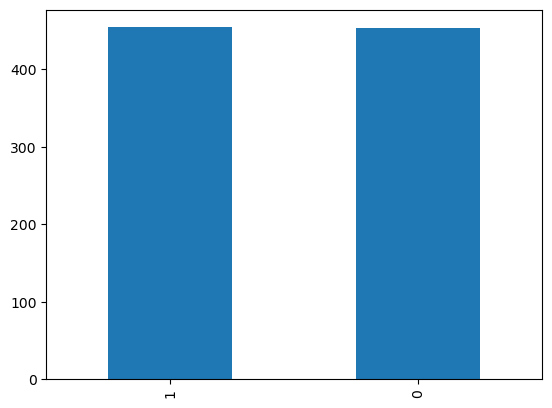

In [8]:
pd.Series(true_labels).value_counts().plot(kind="bar")
print(pd.Series(true_labels).value_counts())

In [9]:
print(f"BERT Accuracy: {metric.compute(predictions=pred_labels_bert, references=true_labels)}")

BERT Accuracy: {'accuracy': 0.8577728776185226}


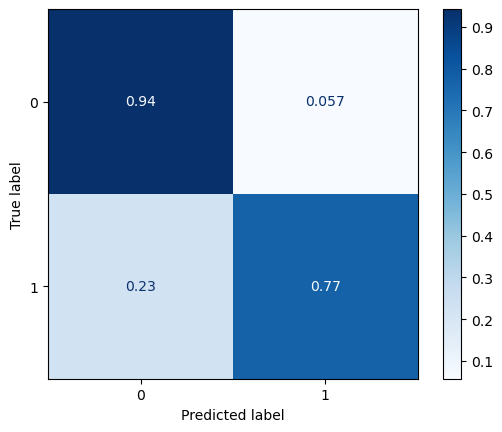

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels_bert, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels_bert, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

# KNN 

In [1]:
from gensim.models import Word2Vec
import numpy as np
import pickle

In [6]:
w2v_model = Word2Vec.load("models/word2vec_knn.model")
vocab=list(w2v_model.wv.key_to_index.keys())
loaded_model = pickle.load(open('models/knn_pickle', 'rb'))

In [7]:
def avg_w2vec(sentences, labels):
    """
    Average Word2Vec approach for creating a vector for a given sentence from the word embeddings of each words of the sentence.
    """

    transformed=[]
    lab = []
    for sentence, label in zip(sentences,labels):
        count=0
        vector=np.zeros(300)
        for word in sentence.split():
            if word in vocab:
                vector+=w2v_model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
            lab.append(label)
    return np.array(transformed), np.array(lab)

In [8]:
transformed_text, labels1= avg_w2vec(sentences, labels)

NameError: name 'sentences' is not defined

In [125]:
pred_labels_knn = loaded_model.predict(transformed_text)

In [126]:
print(len(pred_labels_knn))
print(len(sentences))

22145
22193


In [127]:
np.unique(pred_labels_knn, return_counts=True)[1][1]/len(pred_labels_knn)

0.18044705351095056

In [11]:
sentences = ["so walking to school", "so is school", "so is to school", "so is walking school", "so is walking to school", "so he to school", "so he walking school", "so he walking to school", "so he is school", "so he is to school", "so he is walking school", "so he is walking to school"]

labels = [1] * len(sentences)

transformed_text, labels1= avg_w2vec(sentences, labels)

pred_labels_knn = loaded_model.predict(transformed_text)
print(pred_labels_knn)

[0 0 0 0 0 0 0 0 0 0 0 0]
